In [1]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow import keras

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Reading the dataset

- df_ok: labels of ok gauges
- df_delta: labels of delta gauges
- df_ raw: raw data cointaining the full reading of each gauge

In [2]:
df_delta = pd.read_csv('data/datasets/df_delta.csv') # cointains labels for delta VG
df_ok = pd.read_csv('data/datasets/df_ok.csv')  #contains labels for ok VG

df_raw = pd.read_csv('data/datasets/df_raw.csv') ## contains full reading of each VG

df_labels = pd.concat([df_ok, df_delta], sort=False, axis=0)


df_VG = pd.merge(df_raw, df_labels, on =['gauge_id','fillNumber'])
df_VG = df_VG.set_index(['gauge_id','fillNumber'], drop=True)

## Removing categorical values
df_VG.y.replace(to_replace=['ok', 'delta'], value=[0, 1], inplace=True)

## Splitting the dataset in input and target
- X are the input features
- y is the target vector

In [3]:
X = np.array(df_VG.iloc[:, :-1])
y = np.array(df_VG.iloc[:, -1])

## Normalizing the daset across the row

A custom normalization transformer has been defined to perform the row normalization

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler


class RowScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaling_method='Standard'):
        self.scaling_options = ['Standard', 'MinMax', 'MaxAbs', 'Robust']
        assert (scaling_method in self.scaling_options), 'scaling_method:' + scaling_method + ' not in ' + str(self.scaling_options)
        self.scaling_method = scaling_method

        return None

    def fit(self, X, y=None):
        if self.scaling_method == 'Robust':
            self.scaler = RobustScaler()
        elif self.scaling_method == 'MinMax':
            self.scaler = MinMaxScaler()
        elif self.scaling_method == 'Standard':
            self.scaler = StandardScaler()
        elif self.scaling_method == 'MaxAbs':
            self.scaler = MaxAbsScaler()
        return self
    
    def transform(self, X, y=None):
        return self.scaler.fit_transform(X.transpose()).transpose()

scaler = RowScaler('Standard')
X_norm = scaler.fit_transform(X)
# X_norm[0].shape

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.33, random_state=42)
X_train_m = X_train - X_train.mean(axis=0, keepdims=0)


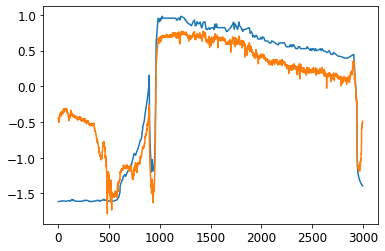

In [6]:
i=100

plt.figure()
plt.plot(range(3000), X_train[i])
plt.plot(range(3000), X_train_m[i])
plt.show()

## Quick overview on the PCA impact

PCA performed on the trainig part of the normalised dataset to visualize its impact.

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

X_train_pca = pca.fit_transform(X_train)
X_train_pca[1]

array([-33.62334369,   6.62523179,  -8.83971902])

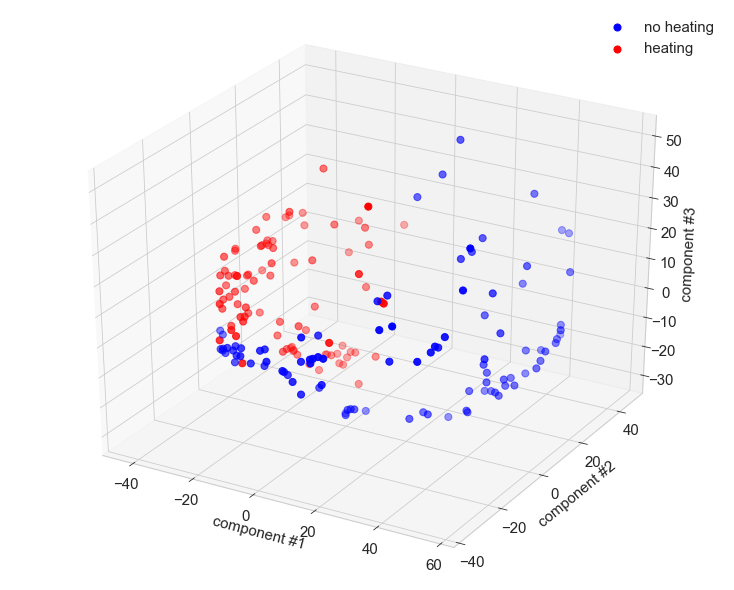

In [8]:
from mpl_toolkits.mplot3d import Axes3D
fontsize=15

ok = X_train_pca[y_train==0]
delta = X_train_pca[y_train ==1]

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

ax.scatter(ok[:,0], ok[:,1], ok[:,2], c='b', label='no heating', s=50)
ax.scatter(delta[:,0], delta[:,1], delta[:,2], c='r', label='heating', s=50)

ax.set_xlabel('component #1', fontsize=fontsize)
ax.set_ylabel('component #2', fontsize=fontsize)
ax.set_zlabel('component #3', fontsize=fontsize)

# ax.set_xlim(-25,30)
# ax.set_ylim(-5,20)
# ax.set_zlim(-10,7.5)
plt.gca().patch.set_facecolor('white')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()


## KNN Pipeline definition

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

knn_clf = Pipeline([
    ('scaler', RowScaler(scaling_method='Standard')),
    ('pca', PCA(n_components=3)),
    ('knn', KNeighborsClassifier())

])

### Quick train to get an overview of the model

In [12]:
from sklearn.metrics import accuracy_score, recall_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)
print(accuracy_score(y_true=y_test, y_pred=y_pred, sample_weight=None))
print(recall_score(y_true=y_test, y_pred=y_pred, sample_weight=None))

0.9347826086956522
0.9387755102040817


## KNN Grid Search

In [15]:
from sklearn.model_selection import GridSearchCV

model = knn_clf
scoring = ['recall', 'accuracy']

param_grid = [
    {'scaler__scaling_method': ['Standard', 'MinMax', 'MaxAbs', 'Robust'], #equivalent of RowScaler().scaling_options
     'pca__n_components': range(2,6),
     'knn__n_neighbors': range(3,7),
     'knn__n_jobs': [-1]
    }
]

from sklearn.model_selection import StratifiedKFold

strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [17]:

print("# Tuning hyper-parameters for {} and {}".format(scoring[0], scoring[1]))
print()

grid_search = GridSearchCV(
    model, param_grid, scoring=scoring, n_jobs=-1,
    verbose=2, cv=strat_kfold, return_train_score=True,
    refit=scoring[0]  #For multiple metric evaluation, this needs to be a string denoting the scorer                               thatwould be used to find the best parameters for refitting the estimator at the                            end.
)
grid_search.fit(X, y)

# Tuning hyper-parameters for recall and accuracy

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  1.1min finished
/Users/Francesco/anaconda3/envs/my_env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        RowScaler(scaling_method='Standard')),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=3, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='aut...
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
    

In [18]:
print("Best parameters set found on development set:")
print()
print(grid_search.best_params_)
print()
print("Grid scores on development set:")
print()
means = grid_search.cv_results_['mean_test_recall']
stds = grid_search.cv_results_['std_test_recall']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Best parameters set found on development set:

{'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'pca__n_components': 4, 'scaler__scaling_method': 'MaxAbs'}

Grid scores on development set:

0.899 (+/-0.071) for {'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'pca__n_components': 2, 'scaler__scaling_method': 'Standard'}
0.885 (+/-0.108) for {'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'pca__n_components': 2, 'scaler__scaling_method': 'MinMax'}
0.791 (+/-0.175) for {'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'pca__n_components': 2, 'scaler__scaling_method': 'MaxAbs'}
0.842 (+/-0.133) for {'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'pca__n_components': 2, 'scaler__scaling_method': 'Robust'}
0.928 (+/-0.064) for {'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'pca__n_components': 3, 'scaler__scaling_method': 'Standard'}
0.928 (+/-0.045) for {'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'pca__n_components': 3, 'scaler__scaling_method': 'MinMax'}
0.957 (+/-0.054) for {'knn__n_jobs': -1, 'knn__n_neighbors': 3, 'pca

In [19]:
grid_search.best_score_

0.9640287769784173

## Saving the model

In [81]:
# for k in sorted(grid_search.cv_results_.keys()):  #printing results keys
#     print('{}'.format(k))

In [20]:
model_dir = 'data/models/knn'
model_name = 'knn_001.pkl'
model_path = os.path.join(model_dir, model_name)
print(model_path)

data/models/knn/knn_001.pkl


In [21]:
if os.path.exists(model_path):
    print(model_path + ' already exist, not overwritten.')
else:
    !mkdir -p {model_dir}
    joblib.dump(grid_search, model_path)
    print(model_path + ' succesfully saved.')


data/models/knn/knn_001.pkl succesfully saved.


## Result Visualization

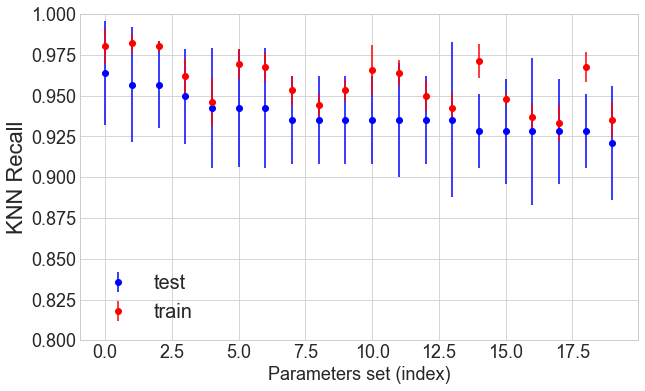

In [23]:
model = joblib.load(model_path)
results = pd.DataFrame(model.cv_results_)

results = results.sort_values(by='rank_test_recall')
results = results.reset_index(drop=True)

n_results = 20
recall_test_mean = results['mean_test_recall'][:n_results]
recall_test_std = results['std_test_recall'][:n_results]

recall_train_mean = results['mean_train_recall'][:n_results]
recall_train_std = results['std_train_recall'][:n_results]

plt.figure(figsize=(10,6))
plt.errorbar(range(n_results), recall_test_mean, yerr=recall_test_std, linestyle='None', marker='o', color='b', label='test')
plt.errorbar(range(n_results), recall_train_mean, yerr=recall_train_std, linestyle='None', marker='o', color='r', label='train')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('Parameters set (index)', fontsize=18)
plt.ylabel('KNN Recall', fontsize=22)
plt.ylim(0.8,1)

# plt.grid('True')
plt.legend(fontsize=20, frameon=False, loc='lower left')
plt.show()
